## Data606 - Capstone Project
```
Group H
Malav Patel, Kent Butler
Prof. Unal Sokaglu
```

This project is about performing time-series analysis on climate data analysis data.



# Research

### References

Some explanations of earth sciences statistics:
https://pjbartlein.github.io/REarthSysSci/ltms-and-anomalies.html

NOAA PSL NCEP-NCAR datasets:  https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html

NOAA PSL, other recognized data sources directory: https://psl.noaa.gov/data/help/othersources/

Global environmental policy timeline, https://www.boell.de/en/2022/05/28/international-environmental-policy-timeline

OECD convergence of policy, climate,and economy: https://www.oecd.org/

NASA climate time machine: https://climate.nasa.gov/interactives/climate-time-machine

### Factoids

* All of the plastic waste produced in the world in 2019 alone weighs as much as 35,000 Eiffel Towers – 353 million tons  - [*Organization for Economic Cooperation and Development (OECD)*](https://www.boell.de/en/2022/05/28/international-environmental-policy-timeline)



## Application Parameters

Note: algorithm tuning is done with declaration of the model.

In [1]:
import pandas as pd
from datetime import datetime as dt
import datetime

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
debug = False

DRIVE_PATH = "/content/drive/MyDrive/data606"

# Set the location of this script in GDrive
SCRIPT_PATH = DRIVE_PATH + "/src/"

# Root Path of the data on the cloud drive
DATA_ROOT = DRIVE_PATH + "/data/"

# Location of logged output prediction data
LOG_PATH = DATA_ROOT + "/preds/"

# Journal file
JOURNAL_LOG = SCRIPT_PATH + "cv-results.csv"

# Start including data from this date
START_DATE =  pd.to_datetime(dt.fromisoformat('1950-01-01'))
# Stop including data after this date
END_DATE = pd.to_datetime(dt.fromisoformat('2015-12-01'))

In [5]:
%cd $SCRIPT_PATH

/content/drive/MyDrive/data606/src


In [6]:
# Load util class
%run -i "./ProjectUtil.ipynb"

In [7]:
# Load util class
%run -i "./ModelExecutor.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data606/src
              A   B      C
2011-01-02   97   1  0.125
2011-01-03   98   2  0.250
2011-01-04   99   3  0.375
2011-01-05  100   4  0.500
2011-01-06  101   5  0.625
2011-01-07  102   6  0.750
2011-01-08  103   7  0.875
2011-01-09  104   8  1.000
2011-01-10  105   9  1.125
2011-01-11  106  10  1.250
2011-01-12  107  11  1.375
2011-01-13  108  12  1.500
2011-01-14  109  13  1.625
2011-01-15  110  14  1.750
2011-01-16  111  15  1.875
2011-01-17  112  16  2.000
2011-01-18  113  17  2.125
2011-01-19  114  18  2.250
2011-01-20  115  19  2.375
2011-01-21  116  20  2.500
2011-01-22  117  21  2.625
2011-01-23  118  22  2.750
Shape: (22, 3)
--- Case 1 ------
 input_width=None, label_width=1, shift=1, label_columns=['A']
Correct outcome - assert error
--- Case 2 ------
 input_width=4, label_width=1, shift=1, label_columns=['A']
Window Gen

**Dataset Definitions**

In [8]:
# Label to predict
TARGET_LABEL = 'landSeaAvgTemp'

# Base dataset
TEMP_DATA = {'filename':'GlobalTemperatures.csv',
             'feature_map':{'LandAndOceanAverageTemperature':'landSeaAvgTemp'},
             'date_col':'dt'}

#TEMP_DATA = {'filename':'GlobalTemperatures.csv',
#              'feature_map':{'LandAverageTemperature':'landAvgTemp',	'LandMaxTemperature':'landMaxTemp',	'LandMinTemperature':'landMinTemp',	'LandAndOceanAverageTemperature':'landSeaAvgTemp'},
#               'date_col':'dt'}

# Datasets
CO2_DATA = {'filename':"atmospheric-co2.csv",
            'feature_map':{'Carbon Dioxide (ppm)':'co2', 'Seasonally Adjusted CO2 (ppm)':'co2_seas'},
            'date_map':{'Year':'year','Month':'month'}}

SEAICE_DATA = {'filename':"seaice.csv",
               'feature_map':{'     Extent':'ice_extent','    Missing':'ice_missing'},
               'date_map':{' Month':'month','Year':'year',' Day':'day'}}

WEATHER_DATA = {'filename':"finalDatasetWithRain.csv",
                'feature_map':{'air_x':'air_x','air_y':'air_y','uwnd':'uwnd'},
                'date_col':'time'}

VOLCANO_DATA = {'filename':'eruptions-conditioned.csv',
                'feature_map':{'vei':'volcanic_idx'},
                'date_map':{'start_year':'year','start_month':'month'}}

FOREST_DATA = {'filename':'WorldForestCover-Interpolated.csv',
               'feature_map':{'PctCover-Int':'pct_forest_cover'},
               'date_col':'date'}

SUNSPOT_DATA = {'filename':'sunspotnumber.csv',
               'feature_map':{'suns_spot_number':'sunspot_num'},
               'date_map':{'year':'year'}}

POLICY_DATA = {'filename':'GlobalEnvPolicies.csv',
               'feature_map':{'EventRating':'policy_rate'},
               'date_col':'date'}

#GHG_DATA = {'filename':'greenhouse_gas_inventory_data.csv',
#            'feature_map':{''},
#            'date_map':{'Year':'year'}}


**Hyperparams**

In [9]:
# History lookback in network
INPUT_WINDOW = 48
# How far forward to predict
LABEL_WINDOW = 5
SHIFT = 1
# Ratio of test data to train data - used for split
TEST_RATIO = 0.2
# 0..1 percent of data to use as validation
VALIDATION_RATIO = 0.1
# Num epochs
NUM_EPOCHS = 300
# Model to use
MODEL_NAME = "LSTMv3"

ALL_DATASETS = [[CO2_DATA],
  [CO2_DATA,FOREST_DATA],
  [CO2_DATA,SEAICE_DATA],
  [CO2_DATA,POLICY_DATA],
  [CO2_DATA,SEAICE_DATA,POLICY_DATA],
  [CO2_DATA,SEAICE_DATA,WEATHER_DATA],
  [CO2_DATA,SEAICE_DATA,WEATHER_DATA,FOREST_DATA],
  [CO2_DATA,SEAICE_DATA,WEATHER_DATA,FOREST_DATA,VOLCANO_DATA],
  [CO2_DATA,SEAICE_DATA,WEATHER_DATA,FOREST_DATA,VOLCANO_DATA,SUNSPOT_DATA],
  [CO2_DATA,VOLCANO_DATA],
  [CO2_DATA,VOLCANO_DATA,FOREST_DATA],
  [CO2_DATA,VOLCANO_DATA,FOREST_DATA,SEAICE_DATA],
  [CO2_DATA,VOLCANO_DATA,FOREST_DATA,SEAICE_DATA,SUNSPOT_DATA],
  [CO2_DATA,FOREST_DATA],
  [CO2_DATA,FOREST_DATA,SEAICE_DATA],
  [CO2_DATA,FOREST_DATA,SEAICE_DATA,SUNSPOT_DATA],
  [VOLCANO_DATA],
  [VOLCANO_DATA,FOREST_DATA],
  [VOLCANO_DATA,POLICY_DATA],
  [VOLCANO_DATA,FOREST_DATA,SUNSPOT_DATA],
  [VOLCANO_DATA,FOREST_DATA,SUNSPOT_DATA,POLICY_DATA],
  [VOLCANO_DATA,FOREST_DATA,SUNSPOT_DATA,POLICY_DATA,SEAICE_DATA],
  [FOREST_DATA],
  [FOREST_DATA,POLICY_DATA],
  [SEAICE_DATA],
  [SEAICE_DATA,FOREST_DATA],
  [SEAICE_DATA,POLICY_DATA],
  [SEAICE_DATA,FOREST_DATA,VOLCANO_DATA],
  [SEAICE_DATA,FOREST_DATA,VOLCANO_DATA,POLICY_DATA]
]

In [10]:
#ALL_DATASETS=[ALL_DATASETS[1]]
ALL_DATASETS=[[SEAICE_DATA, VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA, CO2_DATA, WEATHER_DATA, POLICY_DATA]]

# Execute Trainer

============================ Executing 0 ===================================
LSTMv3-48/5-['seaice.csv', 'eruptions-conditioned.csv', 'WorldForestCover-Interpolated.csv', 'sunspotnumber.csv', 'atmospheric-co2.csv', 'finalDatasetWithRain.csv', 'GlobalEnvPolicies.csv']
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/GlobalTemperatures.csv

 ### Defaulting df_aggr to reference df
------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          31

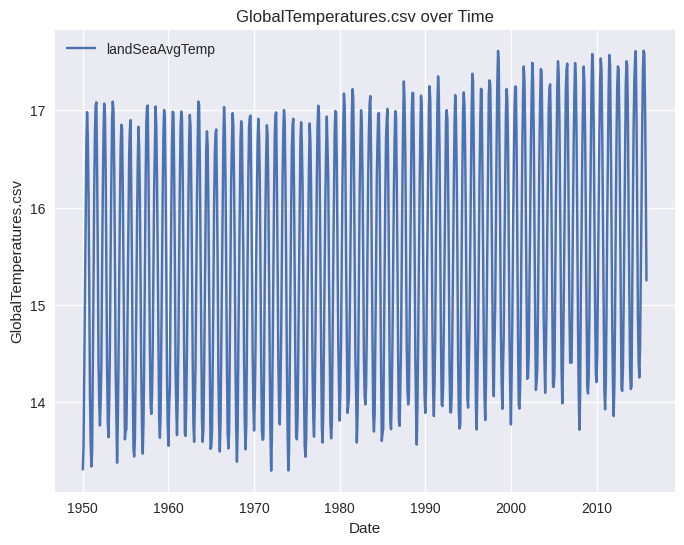

#### Feature map: <class 'dict'> dict_values(['landSeaAvgTemp'])
------------------------------------------
 ### assess_granularity for cols: ['landSeaAvgTemp']
 ### After grouping y/m/d: 791
 ### After grouping y/m: 791
 ### After grouping y: 66
Dataset assessed at timestep freq: M
  _date_  day year month landSeaAvgTemp month-sin month-cos
0    0.0  0.0  0.0   0.0            0.0       0.0       0.0
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/seaice.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26354 entries, 0 to 26353
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          26354 non-null  int64  
 1   month         26354 non-null  int64  
 2   day           26354 non-null  int64  
 3   ice_extent    26354 non-null  f

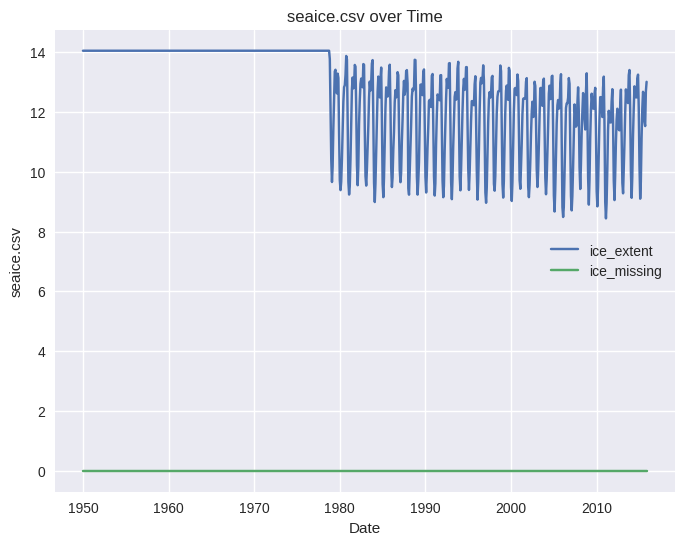

        _date_  day  year  month  landSeaAvgTemp  month-sin     month-cos  \
0   1950-01-01  1.0  1950      1          13.311   0.500000  8.660254e-01   
1   1950-02-01  1.0  1950      2          13.554   0.866025  5.000000e-01   
2   1950-03-01  1.0  1950      3          14.296   1.000000  6.123234e-17   
3   1950-04-01  1.0  1950      4          15.093   0.866025 -5.000000e-01   
4   1950-05-01  1.0  1950      5          16.033   0.500000 -8.660254e-01   
..         ...  ...   ...    ...             ...        ...           ...   
786 2015-07-01  1.0  2015      7          17.611  -0.500000 -8.660254e-01   
787 2015-08-01  1.0  2015      8          17.589  -0.866025 -5.000000e-01   
788 2015-09-01  1.0  2015      9          17.049  -1.000000 -1.836970e-16   
789 2015-10-01  1.0  2015     10          16.290  -0.866025  5.000000e-01   
790 2015-11-01  1.0  2015     11          15.252  -0.500000  8.660254e-01   

     ice_extent  ice_missing  
0     14.050833          0.0  
1     14.0508

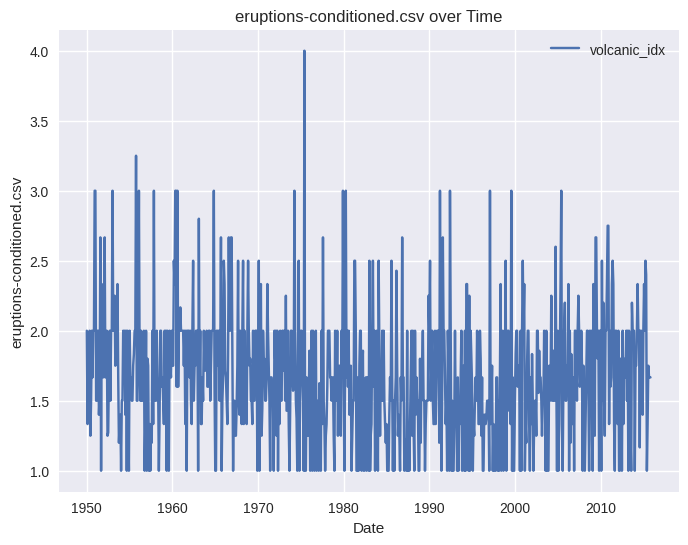

        _date_  day  year  month  landSeaAvgTemp  month-sin     month-cos  \
0   1950-01-01  1.0  1950      1          13.311   0.500000  8.660254e-01   
1   1950-02-01  1.0  1950      2          13.554   0.866025  5.000000e-01   
2   1950-03-01  1.0  1950      3          14.296   1.000000  6.123234e-17   
3   1950-04-01  1.0  1950      4          15.093   0.866025 -5.000000e-01   
4   1950-05-01  1.0  1950      5          16.033   0.500000 -8.660254e-01   
..         ...  ...   ...    ...             ...        ...           ...   
786 2015-07-01  1.0  2015      7          17.611  -0.500000 -8.660254e-01   
787 2015-08-01  1.0  2015      8          17.589  -0.866025 -5.000000e-01   
788 2015-09-01  1.0  2015      9          17.049  -1.000000 -1.836970e-16   
789 2015-10-01  1.0  2015     10          16.290  -0.866025  5.000000e-01   
790 2015-11-01  1.0  2015     11          15.252  -0.500000  8.660254e-01   

     ice_extent  ice_missing  volcanic_idx  
0     14.050833          0.0  

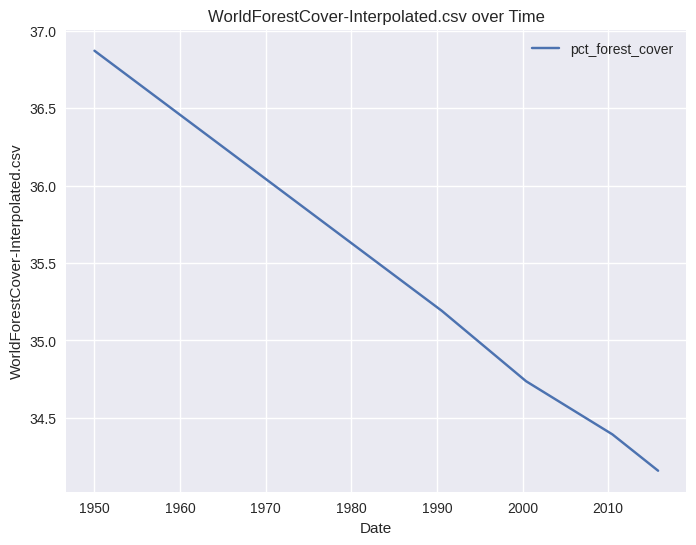

        _date_  day  year  month  landSeaAvgTemp  month-sin     month-cos  \
0   1950-01-01  1.0  1950      1          13.311   0.500000  8.660254e-01   
1   1950-02-01  1.0  1950      2          13.554   0.866025  5.000000e-01   
2   1950-03-01  1.0  1950      3          14.296   1.000000  6.123234e-17   
3   1950-04-01  1.0  1950      4          15.093   0.866025 -5.000000e-01   
4   1950-05-01  1.0  1950      5          16.033   0.500000 -8.660254e-01   
..         ...  ...   ...    ...             ...        ...           ...   
786 2015-07-01  1.0  2015      7          17.611  -0.500000 -8.660254e-01   
787 2015-08-01  1.0  2015      8          17.589  -0.866025 -5.000000e-01   
788 2015-09-01  1.0  2015      9          17.049  -1.000000 -1.836970e-16   
789 2015-10-01  1.0  2015     10          16.290  -0.866025  5.000000e-01   
790 2015-11-01  1.0  2015     11          15.252  -0.500000  8.660254e-01   

     ice_extent  ice_missing  volcanic_idx  pct_forest_cover  
0     14.050

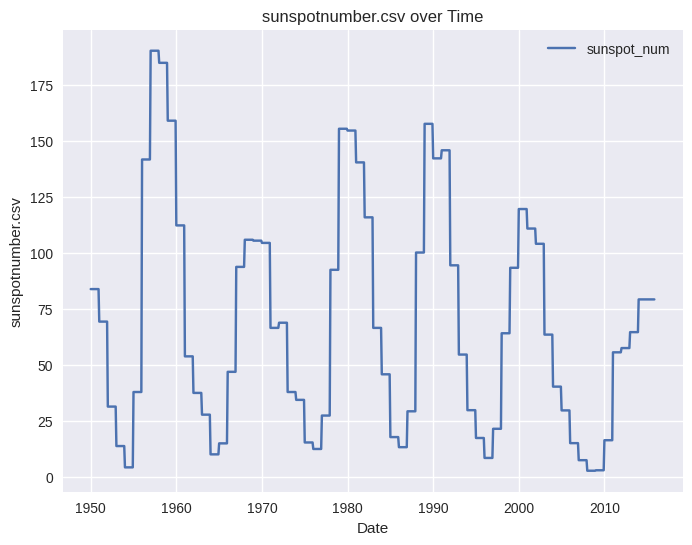

        _date_  day  year  month  landSeaAvgTemp  month-sin     month-cos  \
0   1950-01-01  1.0  1950      1          13.311   0.500000  8.660254e-01   
1   1950-02-01  1.0  1950      2          13.554   0.866025  5.000000e-01   
2   1950-03-01  1.0  1950      3          14.296   1.000000  6.123234e-17   
3   1950-04-01  1.0  1950      4          15.093   0.866025 -5.000000e-01   
4   1950-05-01  1.0  1950      5          16.033   0.500000 -8.660254e-01   
..         ...  ...   ...    ...             ...        ...           ...   
786 2015-07-01  1.0  2015      7          17.611  -0.500000 -8.660254e-01   
787 2015-08-01  1.0  2015      8          17.589  -0.866025 -5.000000e-01   
788 2015-09-01  1.0  2015      9          17.049  -1.000000 -1.836970e-16   
789 2015-10-01  1.0  2015     10          16.290  -0.866025  5.000000e-01   
790 2015-11-01  1.0  2015     11          15.252  -0.500000  8.660254e-01   

     ice_extent  ice_missing  volcanic_idx  pct_forest_cover  sunspot_num  

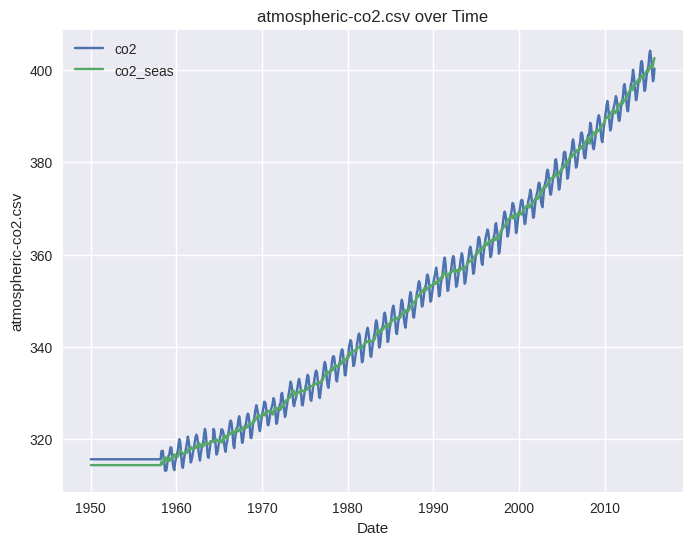

        _date_  day  year  month  landSeaAvgTemp  month-sin     month-cos  \
0   1950-01-01  1.0  1950      1          13.311   0.500000  8.660254e-01   
1   1950-02-01  1.0  1950      2          13.554   0.866025  5.000000e-01   
2   1950-03-01  1.0  1950      3          14.296   1.000000  6.123234e-17   
3   1950-04-01  1.0  1950      4          15.093   0.866025 -5.000000e-01   
4   1950-05-01  1.0  1950      5          16.033   0.500000 -8.660254e-01   
..         ...  ...   ...    ...             ...        ...           ...   
786 2015-07-01  1.0  2015      7          17.611  -0.500000 -8.660254e-01   
787 2015-08-01  1.0  2015      8          17.589  -0.866025 -5.000000e-01   
788 2015-09-01  1.0  2015      9          17.049  -1.000000 -1.836970e-16   
789 2015-10-01  1.0  2015     10          16.290  -0.866025  5.000000e-01   
790 2015-11-01  1.0  2015     11          15.252  -0.500000  8.660254e-01   

     ice_extent  ice_missing  volcanic_idx  pct_forest_cover  sunspot_num  

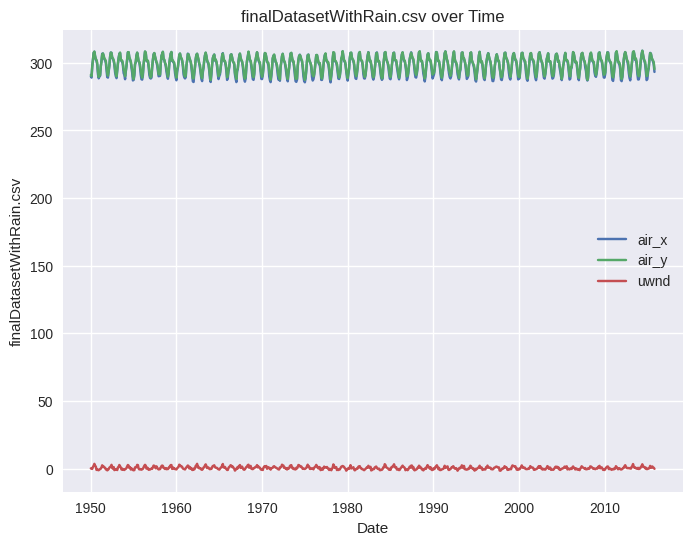

        _date_  day  year  month  landSeaAvgTemp  month-sin     month-cos  \
0   1950-01-01  1.0  1950      1          13.311   0.500000  8.660254e-01   
1   1950-02-01  1.0  1950      2          13.554   0.866025  5.000000e-01   
2   1950-03-01  1.0  1950      3          14.296   1.000000  6.123234e-17   
3   1950-04-01  1.0  1950      4          15.093   0.866025 -5.000000e-01   
4   1950-05-01  1.0  1950      5          16.033   0.500000 -8.660254e-01   
..         ...  ...   ...    ...             ...        ...           ...   
786 2015-07-01  1.0  2015      7          17.611  -0.500000 -8.660254e-01   
787 2015-08-01  1.0  2015      8          17.589  -0.866025 -5.000000e-01   
788 2015-09-01  1.0  2015      9          17.049  -1.000000 -1.836970e-16   
789 2015-10-01  1.0  2015     10          16.290  -0.866025  5.000000e-01   
790 2015-11-01  1.0  2015     11          15.252  -0.500000  8.660254e-01   

     ice_extent  ice_missing  volcanic_idx  pct_forest_cover  sunspot_num  

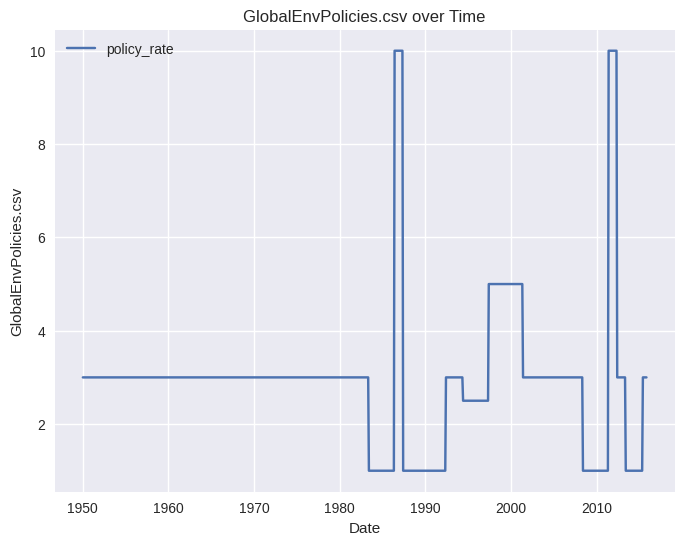

        _date_  day  year  month  landSeaAvgTemp  month-sin     month-cos  \
0   1950-01-01  1.0  1950      1          13.311   0.500000  8.660254e-01   
1   1950-02-01  1.0  1950      2          13.554   0.866025  5.000000e-01   
2   1950-03-01  1.0  1950      3          14.296   1.000000  6.123234e-17   
3   1950-04-01  1.0  1950      4          15.093   0.866025 -5.000000e-01   
4   1950-05-01  1.0  1950      5          16.033   0.500000 -8.660254e-01   
..         ...  ...   ...    ...             ...        ...           ...   
786 2015-07-01  1.0  2015      7          17.611  -0.500000 -8.660254e-01   
787 2015-08-01  1.0  2015      8          17.589  -0.866025 -5.000000e-01   
788 2015-09-01  1.0  2015      9          17.049  -1.000000 -1.836970e-16   
789 2015-10-01  1.0  2015     10          16.290  -0.866025  5.000000e-01   
790 2015-11-01  1.0  2015     11          15.252  -0.500000  8.660254e-01   

     ice_extent  ice_missing  volcanic_idx  pct_forest_cover  sunspot_num  

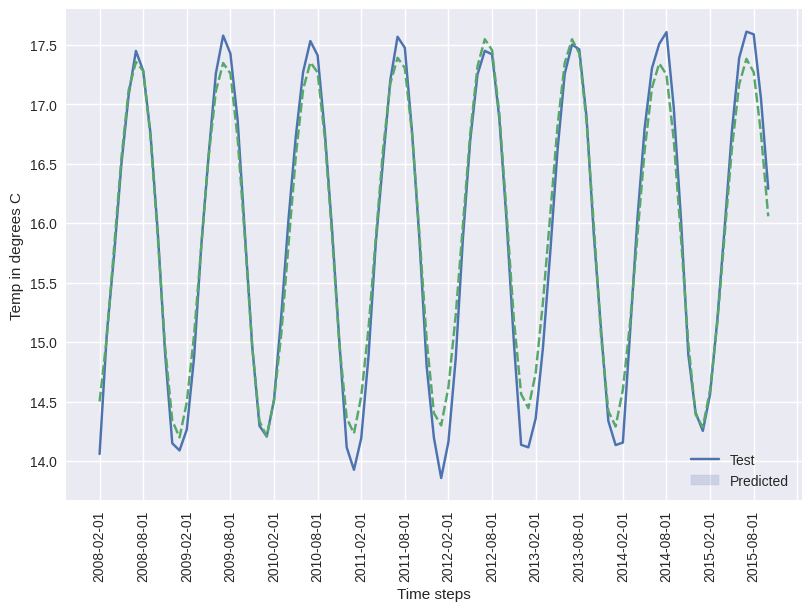

In [11]:

# Declare a merger compatible with our source data and our target dataset we want to merge into
#  (self, data_path, journal_log, start_date, end_date, input_window, label_window, test_ratio, val_ratio, num_epochs, target_label, model_name, debug=False):

for i,ds_list in enumerate(ALL_DATASETS):

  fnames = [ds['filename'] for ds in ds_list]
  print(f'============================ Executing {i} ===================================\n{MODEL_NAME}-{INPUT_WINDOW}/{LABEL_WINDOW}-{fnames}')

  # re-construct the model exec b/c it contains some state
  exec = ModelExecutor(data_path=DATA_ROOT, log_path=LOG_PATH, journal_log=JOURNAL_LOG, start_date=START_DATE, end_date=END_DATE,
                      input_window=INPUT_WINDOW, label_window=LABEL_WINDOW, shift=SHIFT, test_ratio=TEST_RATIO, val_ratio=VALIDATION_RATIO,
                      num_epochs=NUM_EPOCHS, target_label=TARGET_LABEL, model_name=MODEL_NAME, debug=True)

  exec.load_initial_dataset(TEMP_DATA['filename'], TEMP_DATA['feature_map'], date_map=None, date_col=TEMP_DATA['date_col'])

  exec.load_datasets(ds_list)


  #exec.print_correlations()

  exec.process()

  print(f'=========================== Completed {i} ===================================')
